# Project

In [2]:
import pandas as pd
import json as JSON
import numpy as np

from collections import Counter
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

from pyspark.ml.fpm import PrefixSpan
from pyspark.shell import sc
from pyspark.sql.functions import desc
from pyspark.sql.types import Row

import matplotlib.pyplot as plt

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.3.0
      /_/

Using Python version 3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022 16:36:42)
Spark context Web UI available at http://128.179.158.234:4040
Spark context available as 'sc' (master = local[*], app id = local-1666173373160).
SparkSession available as 'spark'.


In [58]:
df = pd.read_csv('keystrokes-recipes.csv')
KEYWORDS = ['Shift', 'Backspace', 'Enter', 'ArrowDown',
            'ArrowLeft', 'ArrowRight', 'ArrowUp', 'End', 'Control', 'CapsLock']
noisy_punct = [',', '.', '-', ':', '(', ')']
#create a copy of the dataset to another csv file

df.to_csv('keystrokes-recipes-modified.csv', index=False)

- ```keystrokes-recipes.csv``` is the original data and we keep it in case we want to look back at one moment
- ```keystrokes-recipes-modified.csv``` is the modified data


## Data cleaning and sorting


Our data consists of a csv file with event dates, user ids, keystrokes and the recipes they wrote.
We clean all the data by working throught the keystrokes first.

* We group the characters into the word written and separate between important keywords typed such as backspace, shift, enter etc. The sequence ['shift', 'p', 'e', 'r'] becomes ['shift', 'per'] 
* We sort by user id to get a better idea of every recipe every student has written.

## Processing the data


The first thing we did was isolate the keystrokes to a new ```json``` file saved in ```data/all_keystrokes.json```

The next step is to group words together and separate them from keywords and we work between each whitespace.
 
So for example this entry: 

```{'time': 1662252404346, 'character': 'Shift'}, {'time': 1662252404376, 'character': 'f'}, {'time': 1662252404505, 'character': 'i'}``` 

gives the following output: 

```{'time': 1662252404346, 'word': 'Shift'}, {'time': 1662252404505, 'word': 'fi'}```


In [4]:
def find_seq(chars):
    return "".join(list(filter(lambda _ : _ not in KEYWORDS, chars)))

def separate_entry(json_values):
    new_data = []
    last_whitespace = 0
    characters = [arr[1] for arr in json_values]

    for i, (time, character) in enumerate(json_values):
        if character.isspace():
            word = characters[last_whitespace: i]
            if not any(i in word for i in KEYWORDS):
                new_data.append({'time': time, 'word': "".join(word)})
            else:
                new_data.append({'time': time, 'word': find_seq(word)})
            last_whitespace = i+1

        elif character in KEYWORDS:
            new_data.append({'time': time, 'word': character})
        
        elif not character:
            continue

    return new_data

def compute():
    new_df = pd.DataFrame(pd.read_json("data/all_keystrokes.json"))
    arr = []
    for jsonf in new_df.values:
        sub_arr = []
        for d in jsonf:
            if d is not None:
                sub_arr.append([d["time"], d["character"]])
        arr.append(sub_arr)

    result = []
    for jsonf in arr:
        result.append(separate_entry(jsonf))

    with open("data/new_data.json", "w") as f:
        JSON.dump(result, f)
    return

compute()



Basically, ``` compute()``` will format the data for the ```separate_entry``` function and when everything is computed, it dumps all the data in a new json file.

```separate_entry``` computes the words between each space character, all the while separating words from keywords. It uses the function ```find_seq``` to separate the characters from keywords so it allows to isolate words between each whitespaces.


## Modifying the CSV file

We just modify the keystroke data for each row of the original data in ```keystrokes-recipes.csv``` but apply it to ```keystrokes-recipes-modified.csv```

In [5]:
jsons = pd.read_json('data/new_data.json').values.tolist()

for i, json in enumerate(jsons):
    jsons[i]= list(filter(lambda _ : _ is not None, json))

def write_to_csv_file(filename, recipes_len):
    df = pd.read_csv(filename)
    for i in range(recipes_len):
        df.loc[i,'ks'] = jsons[i]
    df.to_csv(filename, index=False)

write_to_csv_file('keystrokes-recipes-modified.csv', len(jsons))


## Sorting by user id

We want to sort by user id in order to differentiate behaviour between different people more easily

In [6]:
csv_filename = 'keystrokes-recipes-modified.csv'
pd.read_csv(csv_filename).sort_values(by='user_id', ascending=True).to_csv(csv_filename, index=False)

## Identifying patterns between different student recipes

Count the most common words used in the recipes and removing stopwords (they're noisy)

<AxesSubplot:ylabel='words'>

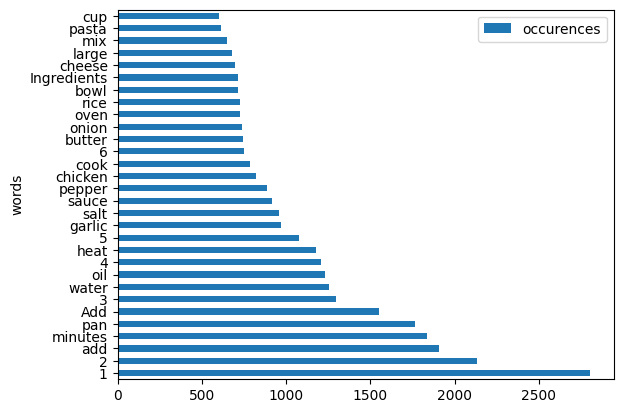

In [7]:
data = pd.read_csv(csv_filename)['recipe'].values
stop_words = set(stopwords.words('english'))
recipes_copy = list(map(lambda _ : word_tokenize(_), data.copy()))
recipes_without_stopwords = []
for recipe in recipes_copy:
    recipes_without_stopwords.append([w for w in recipe if not w.lower() in stop_words])    

flat_list = [item for sublist in recipes_without_stopwords for item in sublist]
flat_list = list(filter(lambda char : char not in noisy_punct, flat_list))
c = Counter(flat_list)

dframe = pd.DataFrame(c.most_common(30))
dframe.columns = ['words', 'occurences']

dframe.plot(kind='barh', x='words', y='occurences', linewidth=1)

Most of the recipes contain an order in which to proceed - ie 1) --- 2) --- 
Also interesting to see most of the common words are not ingredients

### Pattern mining

There are a total of 1091 recipes from 187 students. What we would like to do is either apply pattern mining for each student and their recipes to better understand each users writing. Or, we pick one recipe from each student and extract the underlying patterns each student share.

Given our data, we want to extract the longest common patterns as the shorter ones will only consist of heavily used words such as 'the', 'and'. Hence, given the running time of running the ```PrefixSpan``` algorithm using ```pyspark``` to find the patterns with ```maxPatternLength=10``` is over 10 minutes for only 5 recipes with a little ```minimum_support```, it would take approximately 1870 minutes (1091 recipes and 187 students gives roughly 5 recipes per student) to compute patterns for each student recipes. So, we ought to only pick one from each student and apply the ```PrefixSpan``` algorithm. Regardless - applying prefix span on the written recipes results in unsatisfying output.

To reduce the amount of computation of the algorithm, we simply pick the first recipe each student writes

In [8]:
sorted_df = pd.read_csv(csv_filename)
first_recipe_each_student = sorted_df.groupby('user_id').head(1)
one_recipe_per_student = []
for index in first_recipe_each_student.index:
    one_recipe_per_student.append(word_tokenize((sorted_df.loc[index]['recipe'])))

From, there we can try to apply the PS algorithm

Parameters of ```PrefixSpan``` : 
* Minimum Support (```minSupport```) : support is calculated as the % of sequences containing the subsequence
* Maximum Subsequence Length (```maxPatternLength```) : speaks for itself

If ```minSupport``` is little and ```maxPatternLength``` is large, the running time of ```PrefixSpan``` gets exceedingly long. The contrary gives reasonable running time but some subsequences can be left undiscovered.


<AxesSubplot:ylabel='sequence'>

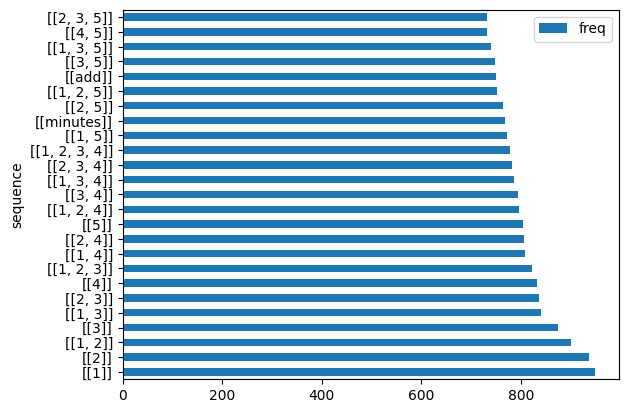

In [9]:
copy = recipes_without_stopwords.copy()

for i, tokenized in enumerate(copy):
    copy[i] = list(filter(lambda char: char not in noisy_punct ,tokenized))

range_ = range(len(copy))
for i in range_:
    copy[i] = Row(sequence=[copy[i]])

l = [copy[i] for i in range_]
DF = sc.parallelize(l).toDF()

prefixSpan = PrefixSpan(minSupport=0.5, maxPatternLength=8, maxLocalProjDBSize=32000000)

# Find frequent sequential patterns.
a = prefixSpan.findFrequentSequentialPatterns(DF).sort(desc('freq')).collect()


NUM_PATTERNS_TO_PLOT = 25

df2 = pd.DataFrame(list(map(lambda _: _.asDict(),a[:NUM_PATTERNS_TO_PLOT])))
df2.plot(kind='barh',x='sequence', y='freq')

Can't really make anything of this which makes sense bc it looks for sequential patterns - not the general idea. For now this just confirms what the frequency word counter showed - that people make a list in their recipes but it's not that interesting.

* What we can do now is try to map each typed character as an insert action, count each backspace as a delete action and from those sequences, generate some patterns under the form (insert - insert - delete - insert ...)

* We can also try to check if any of the commands typed are of the form ```CTRL + C``` - ```CTRL + V``` to see if any of the students might have cheated

* divide the whole writing session in three parts (beginning, middle, end) for each recipe and study different parameters --- such as the number of keystrokes typed at each subsession, the number of inserts or deletions at each subsession and try to see what is the general trend --- without any results i'd personally say more inserts in the beginning and more deletions in the end with slower typing speeds in the middle

### pending approval from thiemo 

I Think of the 3 ideas the one with the insertions and deletions is the most interesting and easy to implement. The idea comes from a paper : Analysis of Keystroke Sequences in Writing Logs


## Comparing text insertions with deletions

First what we want to do is count the number of deletions (ie Backspaces) for each student

we will create a tuple for each student of the form ```(total insertions, total deletions)```

Also, what we do for each user: map their typing to insertions and deletions as 0s for insertions, 1s for deletions and try to see what different sequences of inserts/delete all users have. (so we don't do it for each sample, but for each user, otherwise the algorithm has to go through too many lists of data.)

plot a scatter plot for each student and see if there are correlations

In [35]:
all_keystrokes = pd.read_json('data/all_keystrokes.json').values
sorted_users = sorted(set(df['user_id'].values))
ins_del_dict = {'insert': 0, 'delete': 1}
student_sequences = []

recipe_insertions_deletions = []
user_insertions_deletions = []
for user in sorted_users:
    indices_where_written = np.where(df['user_id'] == user)
    insertions = 0
    deletions = 0
    student_sequence = []
    for index in indices_where_written:
        users_keystrokes = all_keystrokes[index]
        for json in users_keystrokes:
            for dic in json:
                if dic is not None:
                    if dic['character'] not in KEYWORDS:
                        insertions += 1
                        student_sequence.append(ins_del_dict['insert'])
                    elif dic['character'] == 'Backspace':
                        deletions += 1
                        student_sequence.append(ins_del_dict['delete'])
            recipe_insertions_deletions.append((insertions, deletions))
                        
    student_sequences.append(student_sequence)
    user_insertions_deletions.append((insertions, deletions))



0      6502
1      5167
2      4549
3      1581
4      4566
       ... 
182    4634
183    4479
184    2319
185    6780
186    2322
Name: insertions, Length: 187, dtype: int64


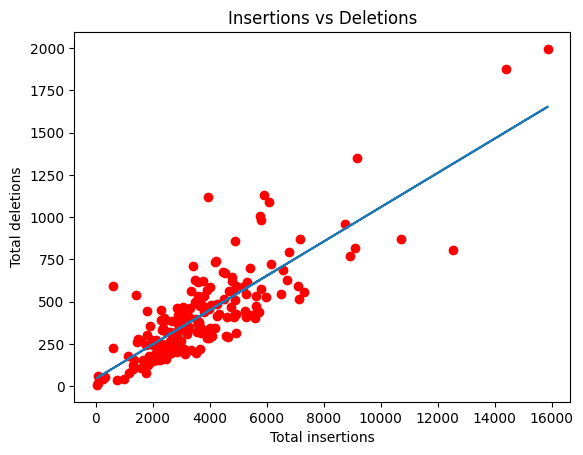

In [32]:
user_df = pd.DataFrame(user_insertions_deletions, columns=['insertions', 'deletions'])

X = user_df['insertions'].values.reshape(-1,1)
Y = user_df['deletions'].values.reshape(-1,1)

from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X,Y)
y_pred = regressor.predict(X)
plt.scatter(X, Y, color='r')
plt.plot(X, y_pred)
plt.title('Insertions vs Deletions')
plt.xlabel('Total insertions')
plt.ylabel('Total deletions')
plt.show()



Applied some linear regression on the mapping because it seems that deletions grow linearly with the number of insertions.

### Finding patterns in student insert/delete sequences


In [12]:
"""sequences = student_sequences
l = [Row(sequence=[s]) for s in sequences]
DF = sc.parallelize(l).toDF()
prefixSpan = PrefixSpan(minSupport=0.3, maxPatternLength=12, maxLocalProjDBSize=32000000)
# Find frequent sequential patterns.
a = prefixSpan.findFrequentSequentialPatterns(DF).sort(desc('freq')).collect()
NUM_PATTERNS_TO_PLOT = 30
df2 = pd.DataFrame(list(map(lambda _: _.asDict(),a[:NUM_PATTERNS_TO_PLOT])))
df2.plot(kind='barh',x='sequence', y='freq')

df2 = pd.DataFrame(list(map(lambda _: _.asDict(),a[NUM_PATTERNS_TO_PLOT: 2*NUM_PATTERNS_TO_PLOT])))
df2.plot(kind='barh',x='sequence', y='freq')
"""

#Takes 14 minutes to run with minSupport = .3 and maxPatternLength = 12


"sequences = student_sequences\nl = [Row(sequence=[s]) for s in sequences]\nDF = sc.parallelize(l).toDF()\nprefixSpan = PrefixSpan(minSupport=0.3, maxPatternLength=12, maxLocalProjDBSize=32000000)\n# Find frequent sequential patterns.\na = prefixSpan.findFrequentSequentialPatterns(DF).sort(desc('freq')).collect()\nNUM_PATTERNS_TO_PLOT = 30\ndf2 = pd.DataFrame(list(map(lambda _: _.asDict(),a[:NUM_PATTERNS_TO_PLOT])))\ndf2.plot(kind='barh',x='sequence', y='freq')\n\ndf2 = pd.DataFrame(list(map(lambda _: _.asDict(),a[NUM_PATTERNS_TO_PLOT: 2*NUM_PATTERNS_TO_PLOT])))\ndf2.plot(kind='barh',x='sequence', y='freq')\n"

### Cheaters?

To try to identify some cheaters in our dataset we can try to see whether some keystrokes have the following consecutive sequence ```CTRL + C, CTRL+V```. If someone copies a part of text, it probably means he will paste it somewhere and if the user pastes some text, it leans towards cheating the system. Now of course we don't know what they paste, perhaps they just copy something they wrote, but maybe they went on some website and copied a recipe. Hence, we add some criteria to whether someone is probably a cheater.

First of all, someone is definitely a cheater if the recipe's number of inserts is lower than the length of the recipe in our dataset. Remember inserts are counted as being any character that is typed which is not a keyword. So if someone types 400 characters for example (without ANY deletions (ie backspaces) which never happens in our data), and the length of the recipe is 700 characters, then that user has definitely copy pasted some recipe from somewhere.

Another criteria is whether a user has copied or pasted some content and the total number of insertions is $<40\%$ the average number of insertions per recipe in our dataset. The $40\%$ threshold is set by us, can also be set to a lower value.

So what we do first is find the indices of the recipes which have the sequences we discussed.

In [85]:
def is_sublist(l,s):
    sub_set = False
    if s == []:
        sub_set = True
    elif s == l:
        sub_set = True
    elif len(s) > len(l):
        sub_set = False

    else: 
        for i in range(len(l)):
            if l[i] == s[0]:
                n = 1
                if i + n < len(l):
                    while (n < len(s)) and (l[i+n] == s[n]):
                        n+=1
                    if n == len(s):
                        sub_set = True

    return sub_set


keystrokes = all_keystrokes
ks_per_recipe = []
for recipe in keystrokes:
    ks = []
    for char in (d['character'] if d is not None else -1 for d in recipe): 
        if char != -1: 
            ks.append(char)
    ks_per_recipe.append(ks)

cheater_subsequence1, cheater_subsequence2 = ['Control', 'c'], ['Control', 'v']


cheater_indices = []
for i, ks in enumerate(ks_per_recipe):
    if is_sublist(ks, cheater_subsequence1) or is_sublist(ks, cheater_subsequence2):
        cheater_indices.append(i)

So now what we do is classify the certain cheaters with the criteria we selected

In [106]:
recipe_df = pd.DataFrame(recipe_insertions_deletions, columns=['insertions', 'deletions'])

average_insertions_per_recipe = recipe_df['insertions'].mean()
average_deletions_per_recipe = recipe_df['deletions'].mean()

certain_cheaters = []
num_times_user_copy_pasted = dict.fromkeys(df['user_id'], 0)

certain_cheater_plot = []
others_plot = []

for index in cheater_indices:
    row_in_data = df.iloc[index]
    num_times_user_copy_pasted[row_in_data['user_id']] += 1
    num_insertions = recipe_df.iloc[index]['insertions']
    recipe_len = len(row_in_data['recipe'])
    if num_insertions < recipe_len or num_insertions < .4 * average_insertions_per_recipe:
        certain_cheaters.append(index)
        certain_cheater_plot.append((num_insertions, recipe_len))
    else:
        others_plot.append((num_insertions, recipe_len))
 

To kind of visualise everything we can plot the values of the ```cheated_indices``` total insertions with the length of the recipe they wrote.
And we set the ones we think are certain cheaters in red and the potential cheaters in blue.

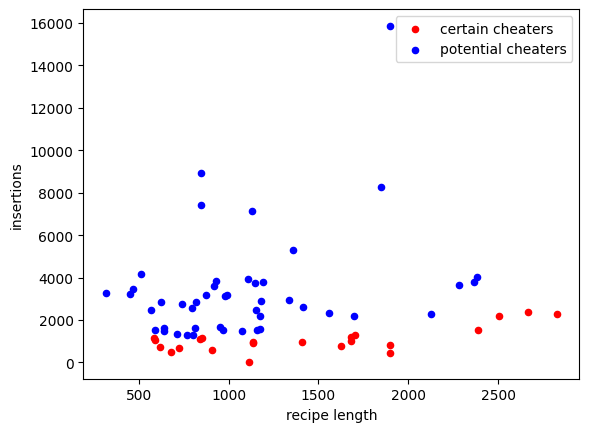

In [111]:
certain_cheaters_df = pd.DataFrame(certain_cheater_plot, columns=['insertions', 'recipe length'])
other_cheaters_df = pd.DataFrame(others_plot, columns=['insertions', 'recipe length'])

ax1 = certain_cheaters_df.plot(kind='scatter', x='recipe length', y='insertions', color='r', label='certain cheaters')    
ax2 = other_cheaters_df.plot(kind='scatter', x='recipe length', y='insertions', color='b', ax=ax1, label='potential cheaters')    
